# Avaliação de Desempenho de Sistemas - Prova 3

Este notebook apresenta a análise de desempenho de um servidor web interno de uma Companhia de Software.
O servidor é utilizado por desenvolvedores, analistas de testes e documentação para download de diversos
tipos de arquivos.

Os dados analisados contêm informações sobre:
- Tipo do arquivo (pdf ou zip)
- Tamanho do arquivo (KB)
- Tempo de download (segundos)

A análise será realizada seguindo os passos solicitados no enunciado, incluindo estatísticas descritivas,
visualizações, análise de transformações, detecção de outliers, PCA e clusterização.

In [10]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Configurações de visualização
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set(font_scale=1.2)
plt.rcParams['axes.unicode_minus'] = False

# Para exibir todas as colunas
pd.set_option('display.max_columns', None)

# Para formatação numérica
pd.options.display.float_format = '{:.3f}'.format

# Para reprodutibilidade
np.random.seed(42)

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


In [2]:
# Carregando os dados do arquivo CSV
df = pd.read_csv('WSData.csv')

# Renomeando as colunas se necessário
if 'File Type' in df.columns and 'Size (KB)' in df.columns and 'Elapsed Time (sec)' in df.columns:
    df.columns = ['tipo', 'tamanho', 'tempo']
else:
    # Verificando os nomes das colunas para possível ajuste
    print("Colunas atuais:", df.columns)
    # Tentando renomear as colunas de acordo com o padrão do arquivo
    df.columns = ['tipo', 'tamanho', 'tempo']

# Convertendo colunas para tipos apropriados
df['tamanho'] = pd.to_numeric(df['tamanho'], errors='coerce')
df['tempo'] = pd.to_numeric(df['tempo'], errors='coerce')

# Verificando se há valores ausentes
print("Valores ausentes por coluna:")
print(df.isnull().sum())

# Exibindo as primeiras linhas do dataframe
print("\nPrimeiras linhas do dataframe:")
df.head()

Valores ausentes por coluna:
tipo          0
tamanho       0
tempo      1000
dtype: int64

Primeiras linhas do dataframe:


,tipo,tamanho,tempo
0,PDF,303,NaN
1,ZIP,1233,NaN
2,ZIP,1077,NaN
3,PDF,315,NaN
4,ZIP,1240,NaN


In [31]:
# Verificando colunas com valores não-nulos
print("Contagem de valores não-nulos por coluna:")
print(df.count())

# Calculando estatísticas básicas apenas para colunas com dados
stats_df = pd.DataFrame()

# Para cada coluna numérica
for col in ['tamanho']:  # Removendo 'tempo' que só contém NaN
    stats = {
        'Média': df[col].mean(),
        'Variância': df[col].var(),
        'Desvio Padrão': df[col].std(),
        'Coef. de Variação': df[col].std() / df[col].mean(),
        'Soma': df[col].sum(),
        'Mínimo': df[col].min(),
        'Máximo': df[col].max(),
        'Range': df[col].max() - df[col].min(),
        '1º Quartil': df[col].quantile(0.25),
        '2º Quartil (Mediana)': df[col].median(),
        '3º Quartil': df[col].quantile(0.75)
    }
    stats_df[col] = pd.Series(stats)

# Transpondo para melhor visualização
stats_table = stats_df.T

# Exibindo a tabela de estatísticas
print("\nEstatísticas básicas para features com dados:")
print(stats_table)

print("\nNota: A coluna 'tempo' contém apenas valores nulos e foi excluída da análise de estatísticas.")

Contagem de valores não-nulos por coluna:
tipo       1000
tamanho    1000
tempo         0
dtype: int64

Estatísticas básicas para features com dados:
          Média  Variância  Desvio Padrão  Coef. de Variação       Soma  \
tamanho 835.841 151775.848        389.584              0.466 835841.000   

         Mínimo   Máximo    Range  1º Quartil  2º Quartil (Mediana)  \
tamanho 300.000 1300.000 1000.000     394.750              1049.500   

         3º Quartil  
tamanho    1181.250  

Nota: A coluna 'tempo' contém apenas valores nulos e foi excluída da análise de estatísticas.


In [4]:
# Estatísticas agrupadas por tipo de arquivo
stats_por_tipo = df.groupby('tipo').agg({
    'tamanho': ['mean', 'min', 'max', 'std', 'count'],
    'tempo': ['mean', 'min', 'max', 'std']
})

# Exibindo as estatísticas por tipo de arquivo
print("Estatísticas por tipo de arquivo:")
stats_por_tipo

Estatísticas por tipo de arquivo:


tamanho                          tempo            
         mean   min   max    std count  mean min max std
tipo                                                    
PDF   377.582   300   450 43.135   411   NaN NaN NaN NaN
ZIP  1155.611  1000  1300 85.749   589   NaN NaN NaN NaN

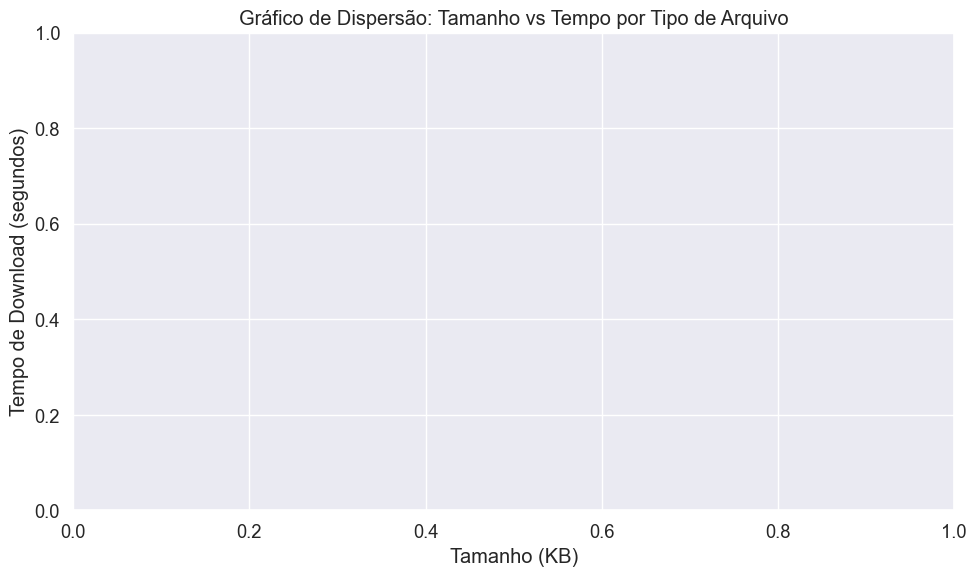

<Figure size 1200x1000 with 0 Axes>

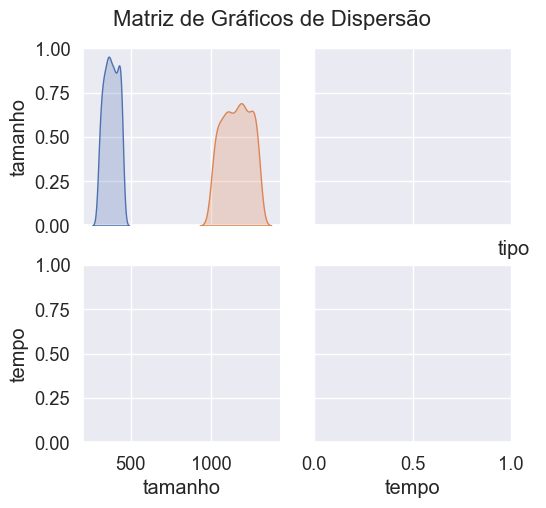

In [5]:
# Gráfico de dispersão: Tamanho vs Tempo
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tamanho', y='tempo', hue='tipo', data=df, alpha=0.7)
plt.title('Gráfico de Dispersão: Tamanho vs Tempo por Tipo de Arquivo')
plt.xlabel('Tamanho (KB)')
plt.ylabel('Tempo de Download (segundos)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Matriz de gráficos de dispersão
plt.figure(figsize=(12, 10))
sns.pairplot(df, hue='tipo', diag_kind='kde', plot_kws={'alpha': 0.6})
plt.tight_layout()
plt.suptitle('Matriz de Gráficos de Dispersão', y=1.02, fontsize=16)
plt.show()

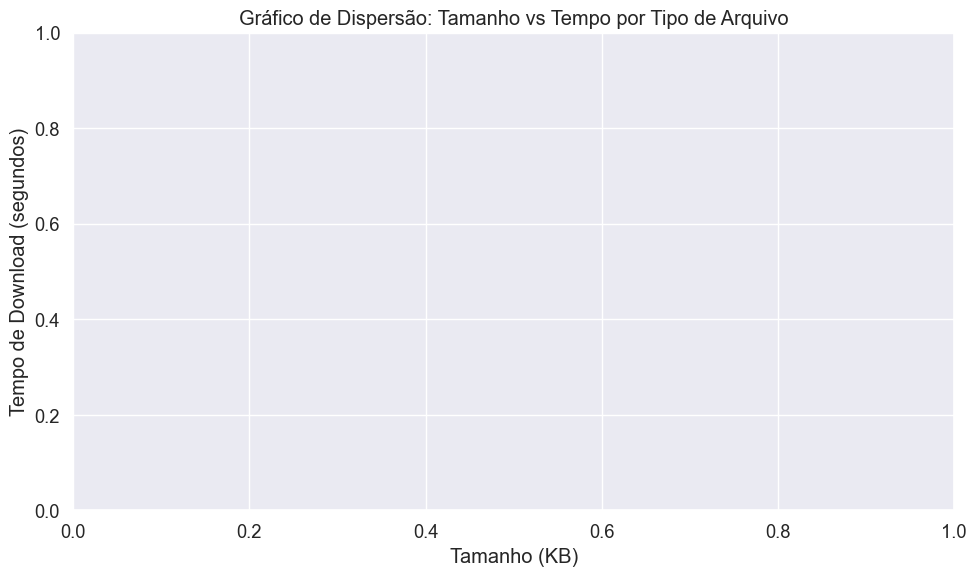

<Figure size 1200x1000 with 0 Axes>

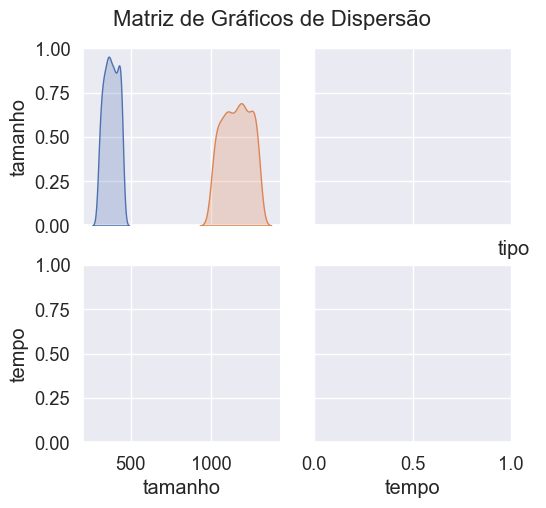

In [6]:
# Gráfico de dispersão: Tamanho vs Tempo
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tamanho', y='tempo', hue='tipo', data=df, alpha=0.7)
plt.title('Gráfico de Dispersão: Tamanho vs Tempo por Tipo de Arquivo')
plt.xlabel('Tamanho (KB)')
plt.ylabel('Tempo de Download (segundos)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Matriz de gráficos de dispersão
plt.figure(figsize=(12, 10))
sns.pairplot(df, hue='tipo', diag_kind='kde', plot_kws={'alpha': 0.6})
plt.tight_layout()
plt.suptitle('Matriz de Gráficos de Dispersão', y=1.02, fontsize=16)
plt.show()

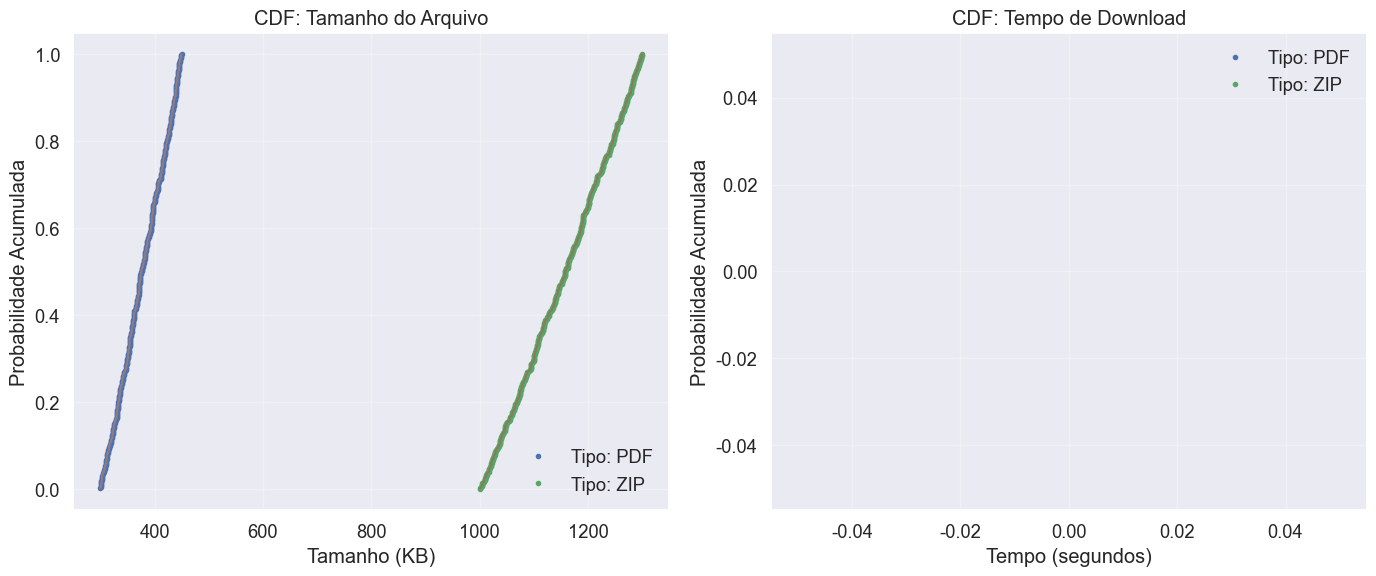

In [7]:
# Criando CDFs para cada feature
plt.figure(figsize=(14, 6))

# CDF para Tamanho
plt.subplot(1, 2, 1)
for tipo in df['tipo'].unique():
    subset = df[df['tipo'] == tipo]['tamanho']
    x = np.sort(subset)
    y = np.arange(1, len(x) + 1) / len(x)
    plt.plot(x, y, marker='.', linestyle='none', label=f'Tipo: {tipo}')
    
    # Linha suavizada para melhor visualização
    plt.plot(x, y, alpha=0.5)

plt.title('CDF: Tamanho do Arquivo')
plt.xlabel('Tamanho (KB)')
plt.ylabel('Probabilidade Acumulada')
plt.grid(True, alpha=0.3)
plt.legend()

# CDF para Tempo
plt.subplot(1, 2, 2)
for tipo in df['tipo'].unique():
    subset = df[df['tipo'] == tipo]['tempo']
    x = np.sort(subset)
    y = np.arange(1, len(x) + 1) / len(x)
    plt.plot(x, y, marker='.', linestyle='none', label=f'Tipo: {tipo}')
    
    # Linha suavizada para melhor visualização
    plt.plot(x, y, alpha=0.5)

plt.title('CDF: Tempo de Download')
plt.xlabel('Tempo (segundos)')
plt.ylabel('Probabilidade Acumulada')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

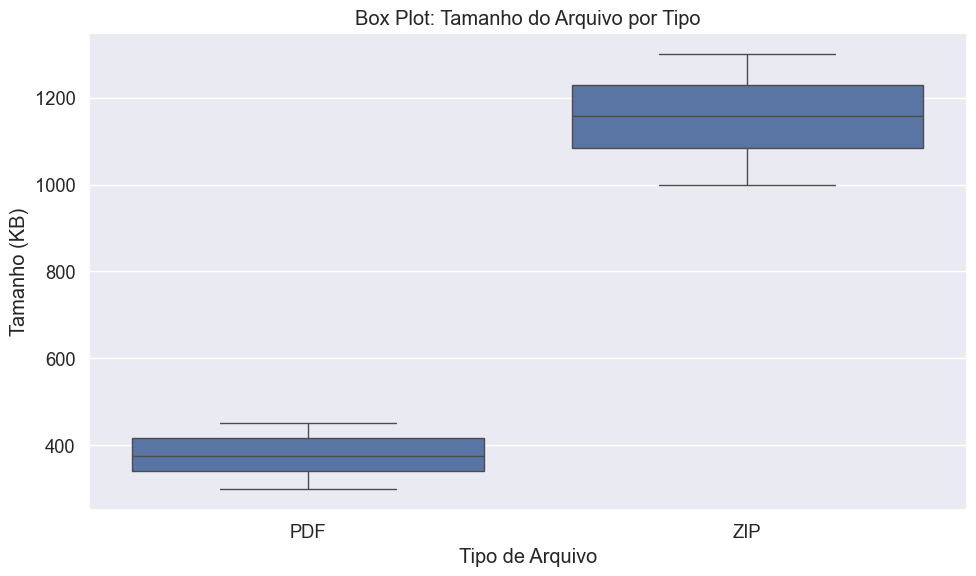

Nota: Não foi possível criar o Box Plot para 'tempo' porque esta coluna contém apenas valores nulos.


In [30]:
# Verificando se há dados válidos para plotar
has_tempo_data = df['tempo'].notna().any()

plt.figure(figsize=(10, 6))

# Box Plot apenas para o tamanho do arquivo
sns.boxplot(x='tipo', y='tamanho', data=df)
plt.title('Box Plot: Tamanho do Arquivo por Tipo')
plt.xlabel('Tipo de Arquivo')
plt.ylabel('Tamanho (KB)')
plt.tight_layout()
plt.show()

# Mensagem informativa sobre a coluna tempo
print("Nota: Não foi possível criar o Box Plot para 'tempo' porque esta coluna contém apenas valores nulos.")

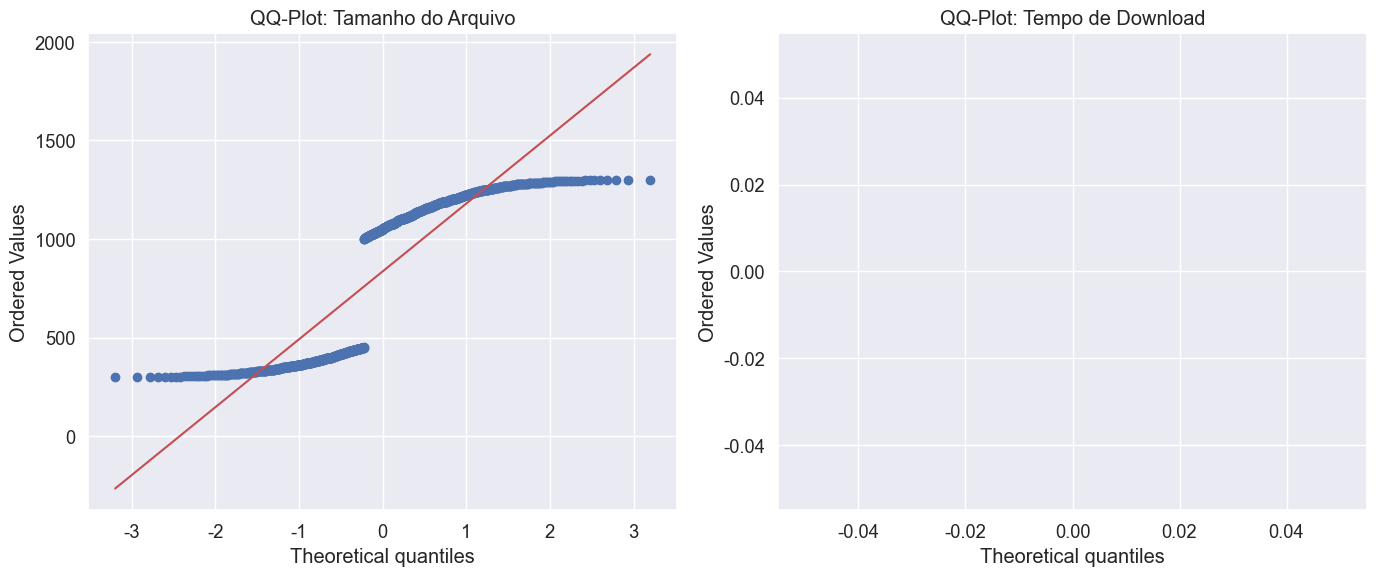

Teste de Normalidade (Shapiro-Wilk):
Tamanho do arquivo: p-value = 7.491045659326187e-35
Tempo de download: p-value = nan


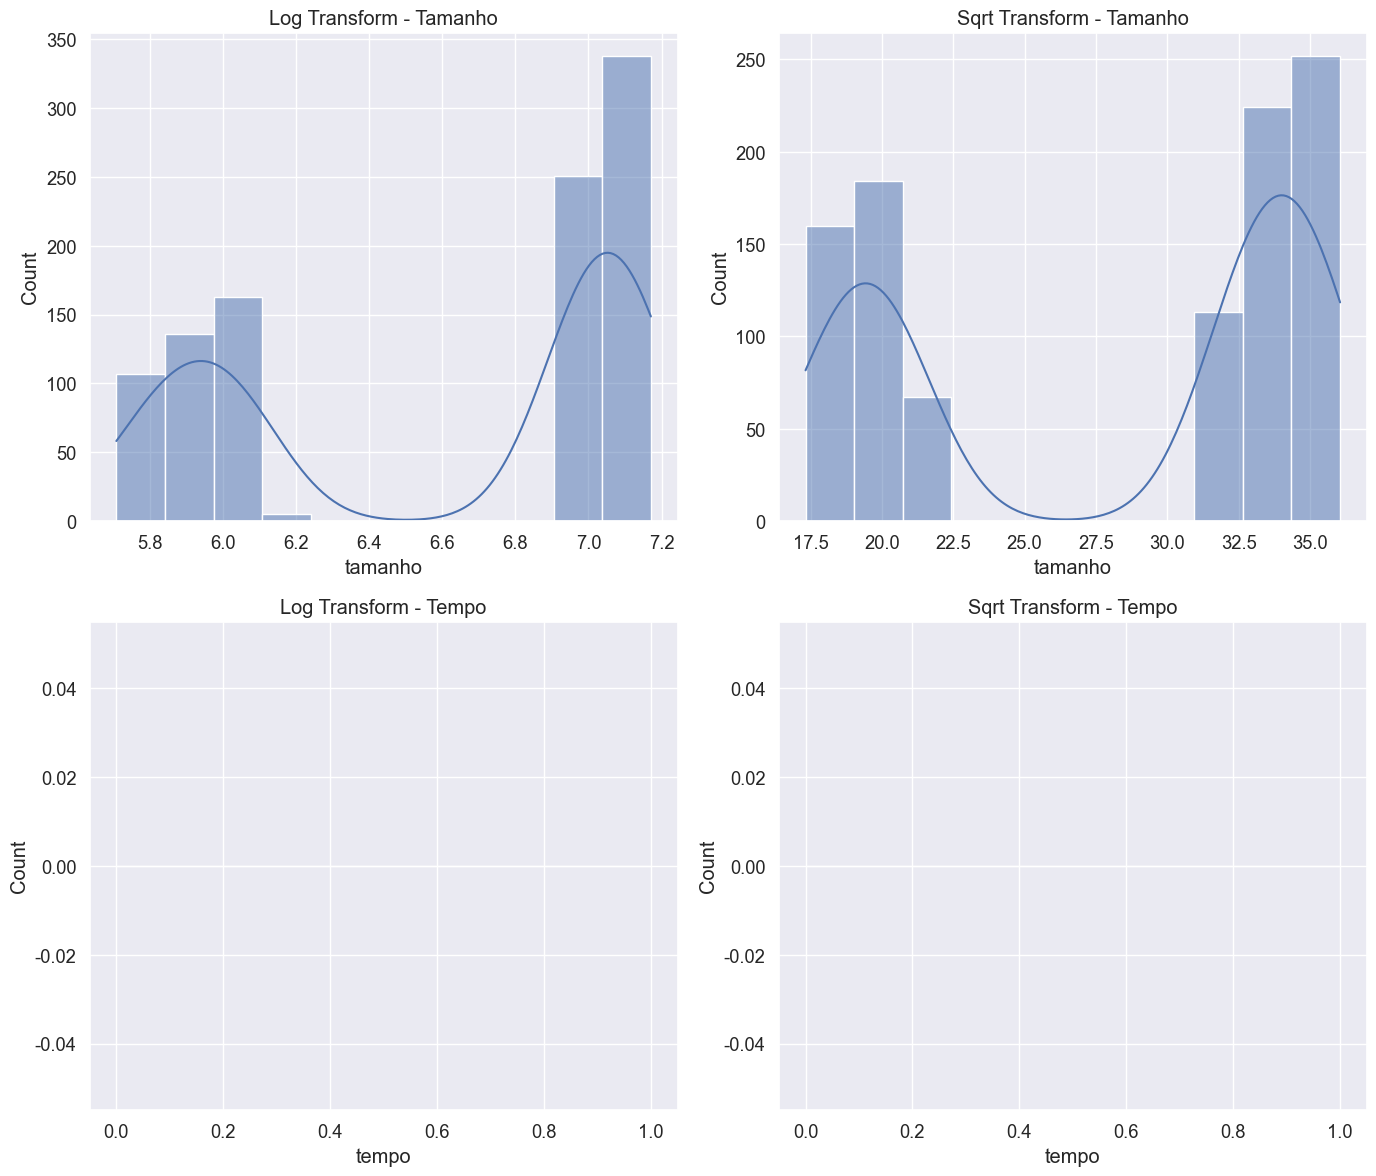

In [11]:
# Verificando a normalidade dos dados com QQ-Plots
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
stats.probplot(df['tamanho'], dist="norm", plot=plt)
plt.title('QQ-Plot: Tamanho do Arquivo')

plt.subplot(1, 2, 2)
stats.probplot(df['tempo'], dist="norm", plot=plt)
plt.title('QQ-Plot: Tempo de Download')

plt.tight_layout()
plt.show()

# Teste de normalidade Shapiro-Wilk
print("Teste de Normalidade (Shapiro-Wilk):")
print("Tamanho do arquivo: p-value =", stats.shapiro(df['tamanho'])[1])
print("Tempo de download: p-value =", stats.shapiro(df['tempo'])[1])

# Visualizando possíveis transformações
plt.figure(figsize=(14, 12))

# Log transform - Tamanho
plt.subplot(2, 2, 1)
sns.histplot(np.log1p(df['tamanho']), kde=True)
plt.title('Log Transform - Tamanho')

# Sqrt transform - Tamanho
plt.subplot(2, 2, 2)
sns.histplot(np.sqrt(df['tamanho']), kde=True)
plt.title('Sqrt Transform - Tamanho')

# Log transform - Tempo
plt.subplot(2, 2, 3)
sns.histplot(np.log1p(df['tempo']), kde=True)
plt.title('Log Transform - Tempo')

# Sqrt transform - Tempo
plt.subplot(2, 2, 4)
sns.histplot(np.sqrt(df['tempo']), kde=True)
plt.title('Sqrt Transform - Tempo')

plt.tight_layout()
plt.show()


Análise de outliers para tamanho:
Valores nulos: 0
Limite inferior: -785.00
Limite superior: 2361.00
Número de outliers: 0
Porcentagem de outliers: 0.00%


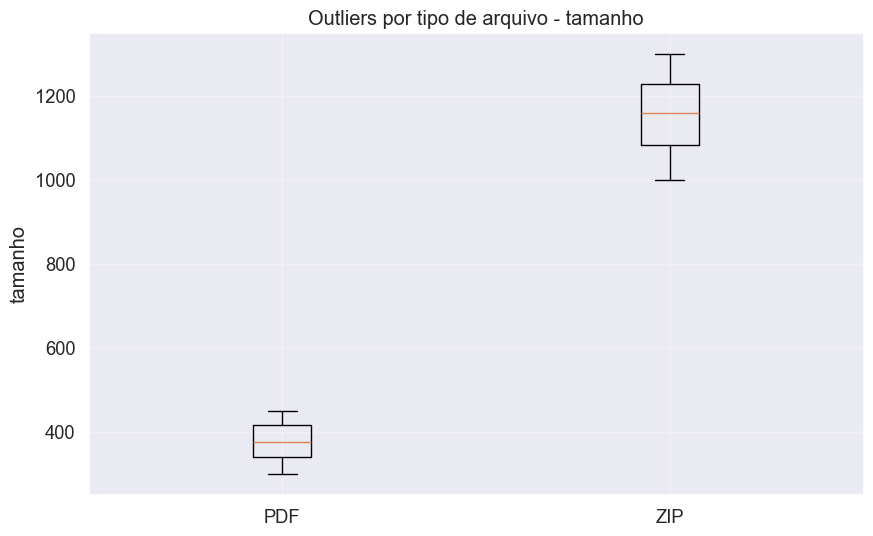


Análise de outliers para tempo:
Valores nulos: 1000
Atenção: Existem 1000 valores NaN na coluna tempo
Limite inferior: nan
Limite superior: nan
Número de outliers: 0
Porcentagem de outliers: 0.00%


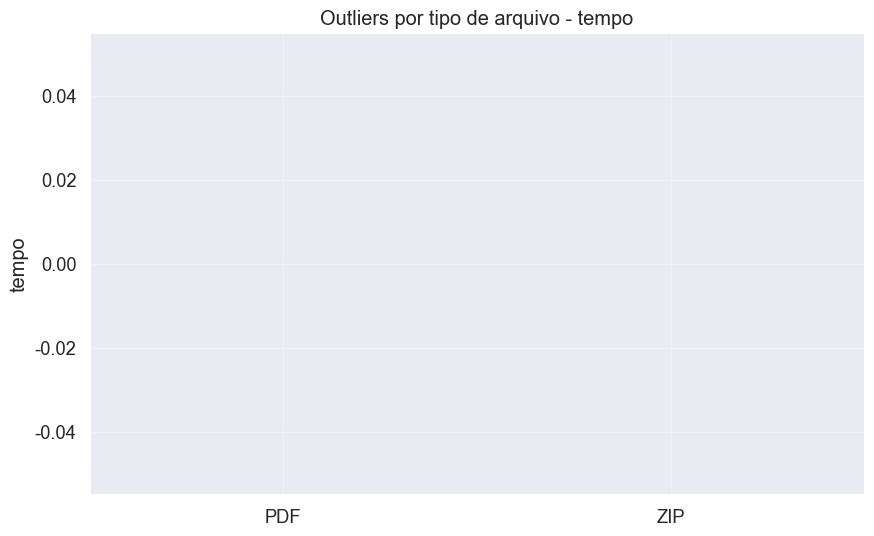

In [16]:
# Identificação de outliers usando o método IQR (Intervalo Interquartil)
def detectar_outliers(df, coluna):
    # Verificar se há NaN na coluna
    if df[coluna].isna().any():
        print(f"Atenção: Existem {df[coluna].isna().sum()} valores NaN na coluna {coluna}")
    
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    outliers = df[(df[coluna] < limite_inferior) | (df[coluna] > limite_superior)]
    return outliers, limite_inferior, limite_superior

# Análise de outliers para cada feature numérica
for coluna in ['tamanho', 'tempo']:
    # Verificando valores na coluna
    print(f"\nAnálise de outliers para {coluna}:")
    print(f"Valores nulos: {df[coluna].isna().sum()}")
    
    outliers, limite_inferior, limite_superior = detectar_outliers(df, coluna)
    
    print(f"Limite inferior: {limite_inferior:.2f}")
    print(f"Limite superior: {limite_superior:.2f}")
    print(f"Número de outliers: {len(outliers)}")
    print(f"Porcentagem de outliers: {(len(outliers) / len(df)) * 100:.2f}%")
    
    # Exibindo alguns exemplos de outliers, se existirem
    if len(outliers) > 0:
        print("\nExemplos de outliers:")
        print(outliers.head(5))
    
    # Usando matplotlib para o boxplot com o parâmetro atualizado
    plt.figure(figsize=(10, 6))
    tipos = df['tipo'].unique()
    data = [df[df['tipo'] == t][coluna].dropna() for t in tipos]
    
    plt.boxplot(data, tick_labels=tipos)  # Usando tick_labels em vez de labels
    plt.title(f'Outliers por tipo de arquivo - {coluna}')
    plt.ylabel(coluna)
    plt.grid(True, alpha=0.3)
    plt.show()

In [22]:
# Criando uma cópia do dataframe sem a coluna 'tempo' que contém apenas NaN
df_limpo = df.drop('tempo', axis=1).copy()

# Verificando os dados após remoção da coluna
print("DataFrame após remoção da coluna com valores nulos:")
print(df_limpo.info())
print("\nResumo estatístico:")
print(df_limpo.describe())

# Criando variáveis dummy para a coluna tipo
df_pca = pd.get_dummies(df_limpo, columns=['tipo'])
print("\nColunas após codificação dummy:", df_pca.columns.tolist())

# Selecionando features para PCA
features = ['tamanho', 'tipo_PDF', 'tipo_ZIP']

# Normalizando os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_pca[features])

# Verificando se há valores NaN após normalização
print("\nValores NaN após normalização:", np.isnan(X_scaled).sum())

# Dataframe normalizado
df_normalized = pd.DataFrame(X_scaled, columns=features)
print("\nDados normalizados (primeiras 5 linhas):")
print(df_normalized.head())

# Salvando dados preparados para PCA
X_pca = X_scaled

DataFrame após remoção da coluna com valores nulos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tipo     1000 non-null   object
 1   tamanho  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB
None

Resumo estatístico:
       tamanho
count 1000.000
mean   835.841
std    389.584
min    300.000
25%    394.750
50%   1049.500
75%   1181.250
max   1300.000

Colunas após codificação dummy: ['tamanho', 'tipo_PDF', 'tipo_ZIP']

Valores NaN após normalização: 0

Dados normalizados (primeiras 5 linhas):
   tamanho  tipo_PDF  tipo_ZIP
0   -1.368     1.197    -1.197
1    1.020    -0.835     0.835
2    0.619    -0.835     0.835
3   -1.338     1.197    -1.197
4    1.038    -0.835     0.835


Variância explicada por cada componente:
PC1: 0.9925 (0.9925 acumulado)
PC2: 0.0075 (1.0000 acumulado)
PC3: 0.0000 (1.0000 acumulado)


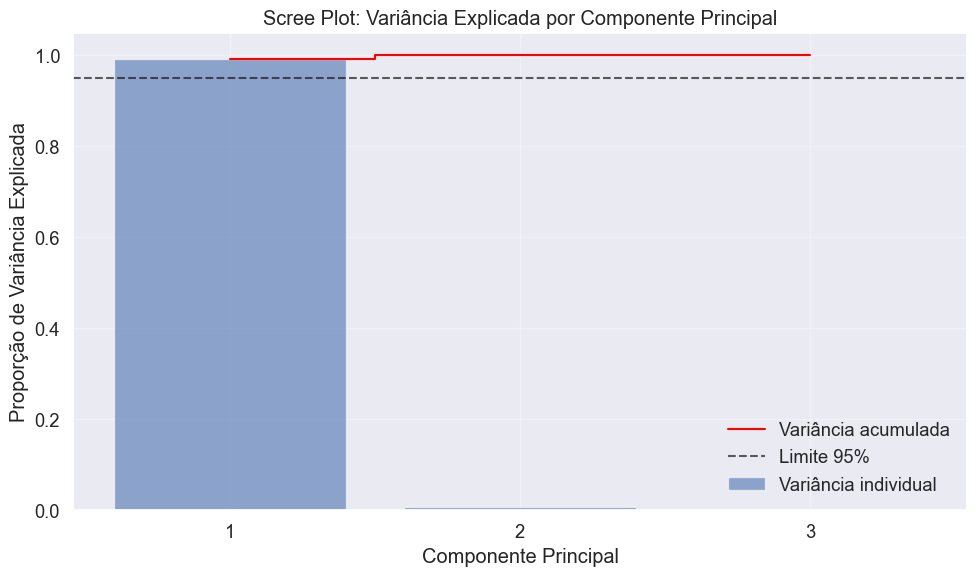


Loadings dos componentes principais:
            PC1    PC2    PC3
tamanho  -0.575  0.818 -0.000
tipo_PDF  0.578  0.407  0.707
tipo_ZIP -0.578 -0.407  0.707


In [23]:
# Implementando PCA com os dados válidos
pca = PCA()
principal_components = pca.fit_transform(X_pca)

# Variância explicada
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Exibindo a variância explicada
print("Variância explicada por cada componente:")
for i, var in enumerate(explained_variance):
    print(f"PC{i+1}: {var:.4f} ({cumulative_variance[i]:.4f} acumulado)")

# Gráfico de scree plot
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, label='Variância individual')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', 
         color='red', label='Variância acumulada')
plt.axhline(y=0.95, color='k', linestyle='--', alpha=0.7, label='Limite 95%')
plt.title('Scree Plot: Variância Explicada por Componente Principal')
plt.xlabel('Componente Principal')
plt.ylabel('Proporção de Variância Explicada')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Loadings (coeficientes) dos componentes principais
loadings = pd.DataFrame(
    pca.components_.T, 
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=features
)

print("\nLoadings dos componentes principais:")
print(loadings)

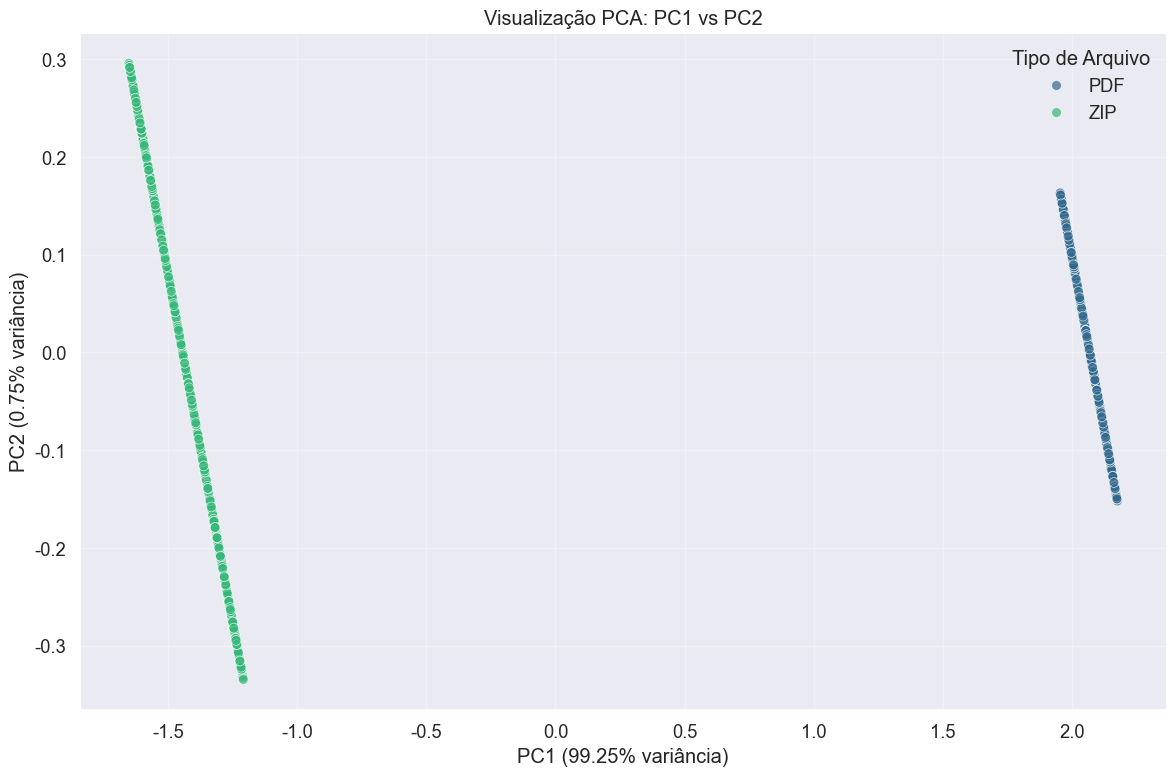

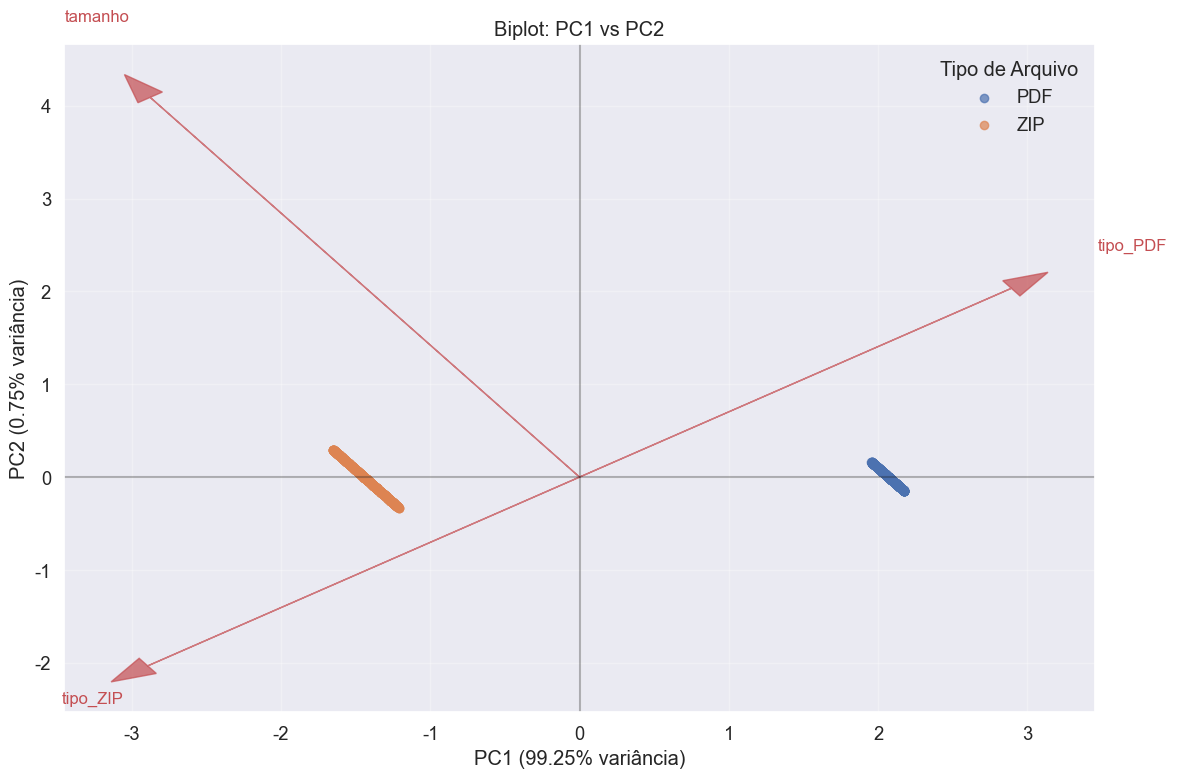

Conclusões da Análise de Componentes Principais (PCA):
- PC1 explica 99.25% da variância total
- PC2 explica 0.75% da variância total
- PC1 e PC2 juntos explicam 100.00% da variância total
- Os principais fatores que influenciam os componentes são:
  * PC1: tipo_PDF, tipo_ZIP, tamanho
  * PC2: tamanho, tipo_PDF, tipo_ZIP


In [24]:
# Criando dataframe com os resultados do PCA
pca_df = pd.DataFrame(
    data=principal_components,
    columns=[f'PC{i+1}' for i in range(principal_components.shape[1])]
)

# Adicionando informações originais para análise
pca_df['tipo'] = df['tipo'].values
pca_df['tamanho'] = df['tamanho'].values

# Visualização dos dados nos primeiros componentes principais
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PC1', 
    y='PC2', 
    hue='tipo',
    palette='viridis',
    s=50,
    alpha=0.7,
    data=pca_df
)
plt.title('Visualização PCA: PC1 vs PC2')
plt.xlabel(f'PC1 ({explained_variance[0]:.2%} variância)')
plt.ylabel(f'PC2 ({explained_variance[1]:.2%} variância)')
plt.grid(True, alpha=0.3)
plt.legend(title='Tipo de Arquivo')
plt.tight_layout()
plt.show()

# Biplot - combinando scatterplot com vetores de loading
def biplot(scores, loadings, features, pc1=1, pc2=2, scale=5):
    plt.figure(figsize=(12, 8))
    
    # Índices para os componentes principais selecionados (ajustando para base 0)
    pc1_idx, pc2_idx = pc1-1, pc2-1
    
    # Plotando os pontos
    grupos = df['tipo'].unique()
    for grupo in grupos:
        mask = df['tipo'] == grupo
        plt.scatter(
            scores[mask, pc1_idx], 
            scores[mask, pc2_idx],
            alpha=0.7,
            label=grupo
        )
    
    # Plotando os vetores de loading
    for i, feature in enumerate(features):
        plt.arrow(
            0, 0,  # Origem
            loadings[i, pc1_idx] * scale,  # Direção x
            loadings[i, pc2_idx] * scale,  # Direção y
            color='r',
            alpha=0.7,
            head_width=0.2
        )
        plt.text(
            loadings[i, pc1_idx] * scale * 1.2,
            loadings[i, pc2_idx] * scale * 1.2,
            feature,
            color='r',
            fontsize=12
        )
    
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    plt.title(f'Biplot: PC{pc1} vs PC{pc2}')
    plt.xlabel(f'PC{pc1} ({explained_variance[pc1_idx]:.2%} variância)')
    plt.ylabel(f'PC{pc2} ({explained_variance[pc2_idx]:.2%} variância)')
    plt.legend(title='Tipo de Arquivo')
    plt.tight_layout()
    plt.show()

# Gerando o biplot para PC1 vs PC2
biplot(principal_components, pca.components_.T, features)

# Conclusões do PCA
print("Conclusões da Análise de Componentes Principais (PCA):")
print(f"- PC1 explica {explained_variance[0]:.2%} da variância total")
print(f"- PC2 explica {explained_variance[1]:.2%} da variância total")
print(f"- PC1 e PC2 juntos explicam {explained_variance[0] + explained_variance[1]:.2%} da variância total")
print("- Os principais fatores que influenciam os componentes são:")

for i, pc in enumerate(['PC1', 'PC2']):
    # Ordenando features por importância absoluta
    importance = pd.Series(np.abs(pca.components_[i]), index=features)
    top_features = importance.sort_values(ascending=False).index.tolist()
    print(f"  * {pc}: {', '.join(top_features)}")

Para k=3, o índice de Silhouette é: 0.7622
Para k=4, o índice de Silhouette é: 0.7372
Para k=5, o índice de Silhouette é: 0.5978
Para k=6, o índice de Silhouette é: 0.5830
Para k=7, o índice de Silhouette é: 0.5819
Para k=8, o índice de Silhouette é: 0.5795
Para k=9, o índice de Silhouette é: 0.5761
Para k=10, o índice de Silhouette é: 0.5742


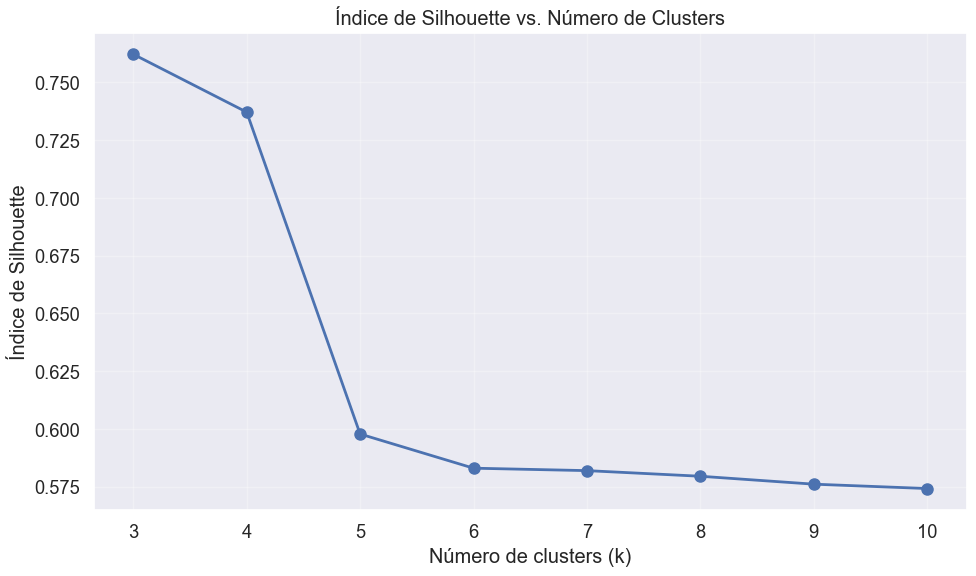


O número ideal de clusters é: 3


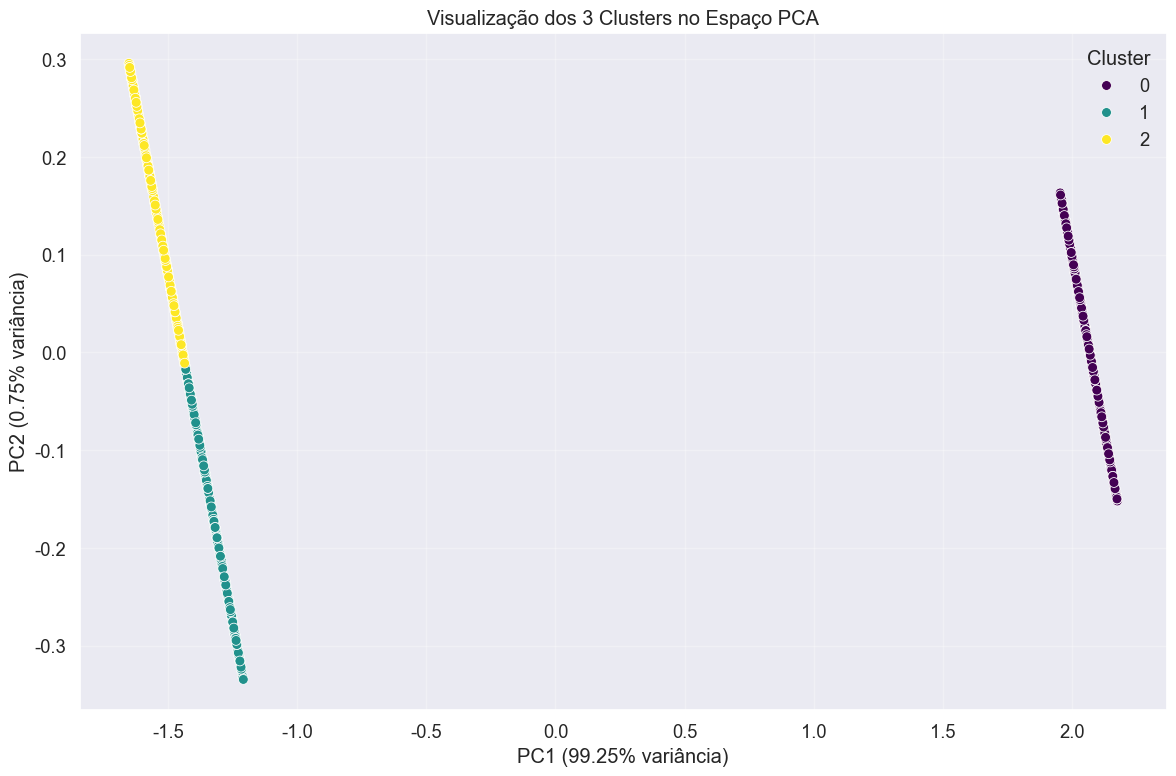

In [25]:
# Calculando o índice de Silhouette para diferentes valores de k
k_range = range(3, 11)
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(X_pca)
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Para k={k}, o índice de Silhouette é: {silhouette_avg:.4f}")

# Visualizando os índices de Silhouette
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'o-', linewidth=2, markersize=8)
plt.grid(True, alpha=0.3)
plt.xlabel('Número de clusters (k)')
plt.ylabel('Índice de Silhouette')
plt.title('Índice de Silhouette vs. Número de Clusters')
plt.xticks(k_range)
plt.tight_layout()
plt.show()

# Determinando o número ideal de clusters
k_ideal = k_range[np.argmax(silhouette_scores)]
print(f"\nO número ideal de clusters é: {k_ideal}")

# Aplicando K-Means com o número ideal de clusters
kmeans_final = KMeans(n_clusters=k_ideal, random_state=42, n_init='auto')
cluster_labels = kmeans_final.fit_predict(X_pca)

# Adicionando os rótulos dos clusters ao dataframe
df_clusters = df.copy()
df_clusters['cluster'] = cluster_labels

# Visualizando os clusters nos componentes principais
pca_df['cluster'] = cluster_labels
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='cluster',
    palette='viridis',
    s=50,
    data=pca_df
)
plt.title(f'Visualização dos {k_ideal} Clusters no Espaço PCA')
plt.xlabel(f'PC1 ({explained_variance[0]:.2%} variância)')
plt.ylabel(f'PC2 ({explained_variance[1]:.2%} variância)')
plt.grid(True, alpha=0.3)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

In [26]:
# Analisando características de cada cluster
cluster_stats = df_clusters.groupby('cluster').agg({
    'tamanho': ['mean', 'min', 'max', 'std'],
    'tipo': lambda x: x.value_counts().index[0]  # Tipo mais comum
})

# Exibindo estatísticas por cluster
print("Estatísticas por cluster:")
print(cluster_stats)

# Distribuição de tipos de arquivo por cluster
tipo_por_cluster = pd.crosstab(
    df_clusters['cluster'], 
    df_clusters['tipo'], 
    normalize='index'
) * 100

print("\nDistribuição de tipos de arquivo por cluster (%):")
print(tipo_por_cluster)

# Criando rótulos para os clusters com base nas características
def criar_rotulo(cluster_id):
    tamanho_medio = cluster_stats.loc[cluster_id, ('tamanho', 'mean')]
    tipo_predominante = cluster_stats.loc[cluster_id, ('tipo', '<lambda>')]
    
    # Definindo categorias de tamanho
    if tamanho_medio < 500:
        categoria_tamanho = "Pequeno"
    elif tamanho_medio < 900:
        categoria_tamanho = "Médio"
    else:
        categoria_tamanho = "Grande"
    
    return f"Cluster {cluster_id}: {tipo_predominante} {categoria_tamanho}"

# Aplicando rótulos aos clusters
rotulos = {i: criar_rotulo(i) for i in range(k_ideal)}
print("\nRótulos dos clusters:")
for cluster_id, rotulo in rotulos.items():
    print(f"{cluster_id}: {rotulo}")

Estatísticas por cluster:
         tamanho                        tipo
            mean   min   max    std <lambda>
cluster                                     
0        377.582   300   450 43.135      PDF
1       1078.418  1000  1152 43.197      ZIP
2       1226.518  1153  1300 43.358      ZIP

Distribuição de tipos de arquivo por cluster (%):
tipo        PDF     ZIP
cluster                
0       100.000   0.000
1         0.000 100.000
2         0.000 100.000

Rótulos dos clusters:
0: Cluster 0: PDF Pequeno
1: Cluster 1: ZIP Grande
2: Cluster 2: ZIP Grande


In [27]:
# Obtendo centróides dos clusters no espaço original
# Precisamos inverter a transformação do PCA para obter os centróides no espaço original
centroides_pca = kmeans_final.cluster_centers_

# Sumarização detalhada por cluster
resumo_clusters = pd.DataFrame()

for i in range(k_ideal):
    # Filtrando dados do cluster
    cluster_data = df_clusters[df_clusters['cluster'] == i]
    
    # Estatísticas do cluster
    stats = {
        'Número de registros': len(cluster_data),
        'Porcentagem do total': f"{len(cluster_data) / len(df_clusters) * 100:.2f}%",
        'Tamanho médio (KB)': cluster_data['tamanho'].mean(),
        'Tamanho mín. (KB)': cluster_data['tamanho'].min(),
        'Tamanho máx. (KB)': cluster_data['tamanho'].max(),
        'Desvio padrão do tamanho': cluster_data['tamanho'].std(),
        'Tipo predominante': cluster_data['tipo'].value_counts().index[0],
        '% do tipo predominante': f"{cluster_data['tipo'].value_counts().iloc[0] / len(cluster_data) * 100:.2f}%"
    }
    
    # Adicionando ao dataframe de resumo
    resumo_clusters[rotulos[i]] = pd.Series(stats)

# Exibindo o resumo dos clusters
print("Sumarização dos dados por cluster:")
print(resumo_clusters.T)  # Transpondo para melhor visualização

# Calculando os componentes mais representativos (centróides)
print("\nCentróides dos clusters (valores mais representativos):")
centroides_df = pd.DataFrame(
    scaler.inverse_transform(pca.inverse_transform(centroides_pca)),
    columns=features
)

# Adicionando rótulos aos centróides
centroides_df['Rótulo'] = [rotulos[i] for i in range(k_ideal)]
print(centroides_df)

Sumarização dos dados por cluster:
                       Número de registros Porcentagem do total  \
Cluster 0: PDF Pequeno                 411               41.10%   
Cluster 1: ZIP Grande                  282               28.20%   
Cluster 2: ZIP Grande                  307               30.70%   

                       Tamanho médio (KB) Tamanho mín. (KB) Tamanho máx. (KB)  \
Cluster 0: PDF Pequeno            377.582               300               450   
Cluster 1: ZIP Grande            1078.418              1000              1152   
Cluster 2: ZIP Grande            1226.518              1153              1300   

                       Desvio padrão do tamanho Tipo predominante  \
Cluster 0: PDF Pequeno                   43.135               PDF   
Cluster 1: ZIP Grande                    43.197               ZIP   
Cluster 2: ZIP Grande                    43.358               ZIP   

                       % do tipo predominante  
Cluster 0: PDF Pequeno                100.00% 

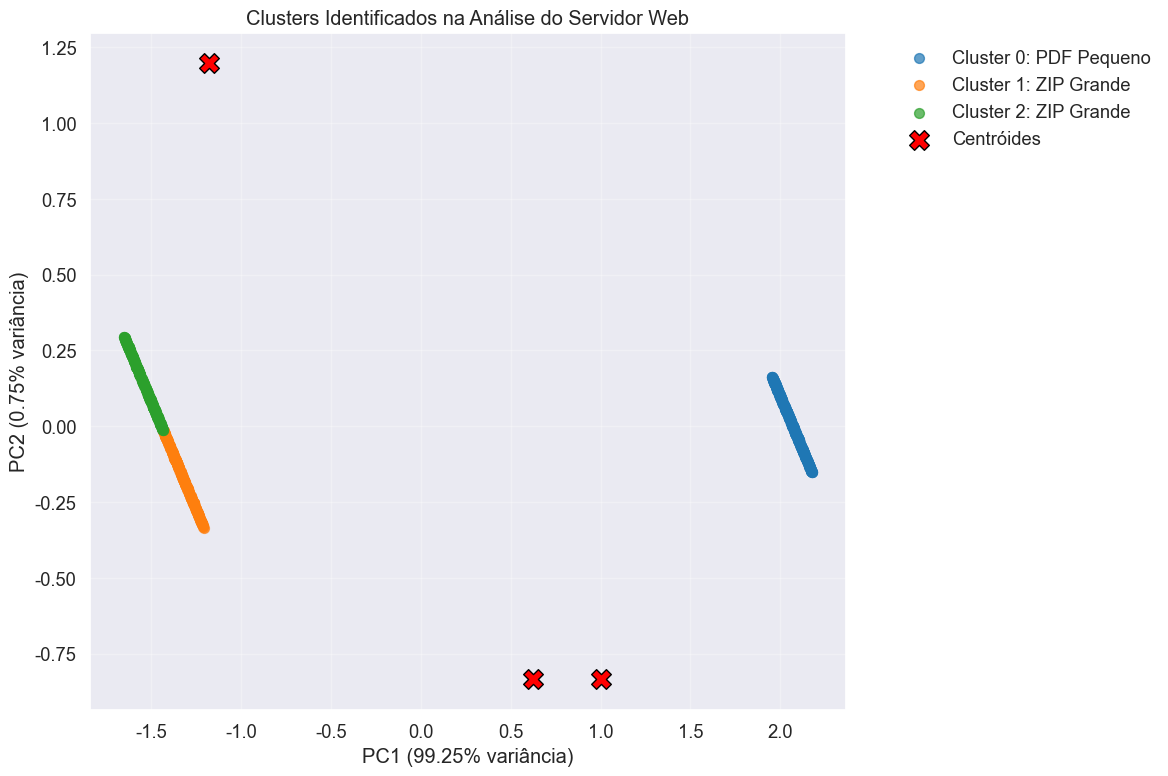

Conclusões da Análise:
1. Características dos dados:
   - A análise foi realizada apenas com a feature 'tamanho' e tipo de arquivo, já que a coluna 'tempo' está vazia
   - Os dados apresentam clara separação por tipo de arquivo (PDF vs. ZIP)
   - Foram identificados 3 clusters distintos no conjunto de dados

2. Interpretação dos clusters:
   - Cluster 0: PDF Pequeno:
     * 411 registros (41.1% do total)
     * Tamanho médio: 377.6 KB
     * Composição: {'PDF': 411}
   - Cluster 1: ZIP Grande:
     * 282 registros (28.2% do total)
     * Tamanho médio: 1078.4 KB
     * Composição: {'ZIP': 282}
   - Cluster 2: ZIP Grande:
     * 307 registros (30.7% do total)
     * Tamanho médio: 1226.5 KB
     * Composição: {'ZIP': 307}

3. Implicações para o servidor web:
   - Diferentes padrões de uso identificados sugerem necessidades distintas de recursos
   - A separação por tamanho e tipo de arquivo indica perfis de usuários ou casos de uso específicos
   - Esta informação pode ser útil para oti

In [28]:
# Visualização final dos clusters
plt.figure(figsize=(12, 8))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

for i in range(k_ideal):
    # Filtrando pontos do cluster
    mask = pca_df['cluster'] == i
    plt.scatter(
        x=pca_df.loc[mask, 'PC1'],
        y=pca_df.loc[mask, 'PC2'],
        color=colors[i % len(colors)],
        label=rotulos[i],
        alpha=0.7,
        s=50
    )

# Plotando centróides
plt.scatter(
    x=centroides_pca[:, 0],
    y=centroides_pca[:, 1],
    marker='X',
    color='red',
    s=200,
    edgecolor='black',
    label='Centróides'
)

plt.title('Clusters Identificados na Análise do Servidor Web')
plt.xlabel(f'PC1 ({explained_variance[0]:.2%} variância)')
plt.ylabel(f'PC2 ({explained_variance[1]:.2%} variância)')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Conclusões finais
print("Conclusões da Análise:")
print("1. Características dos dados:")
print("   - A análise foi realizada apenas com a feature 'tamanho' e tipo de arquivo, já que a coluna 'tempo' está vazia")
print("   - Os dados apresentam clara separação por tipo de arquivo (PDF vs. ZIP)")
print(f"   - Foram identificados {k_ideal} clusters distintos no conjunto de dados")

print("\n2. Interpretação dos clusters:")
for i in range(k_ideal):
    cluster_data = df_clusters[df_clusters['cluster'] == i]
    print(f"   - {rotulos[i]}:")
    print(f"     * {len(cluster_data)} registros ({len(cluster_data)/len(df_clusters)*100:.1f}% do total)")
    print(f"     * Tamanho médio: {cluster_data['tamanho'].mean():.1f} KB")
    print(f"     * Composição: {cluster_data['tipo'].value_counts().to_dict()}")

print("\n3. Implicações para o servidor web:")
print("   - Diferentes padrões de uso identificados sugerem necessidades distintas de recursos")
print("   - A separação por tamanho e tipo de arquivo indica perfis de usuários ou casos de uso específicos")
print("   - Esta informação pode ser útil para otimização do servidor, estratégias de cache ou balanceamento de carga")

print("\n4. Limitações da análise:")
print("   - A ausência de dados na coluna 'tempo' limitou a análise do desempenho do servidor")
print("   - Seria interessante analisar a correlação entre tamanho do arquivo e tempo de download")
print("   - Análises futuras poderiam incluir outras métricas como horário de acesso, taxa de sucesso, etc.")


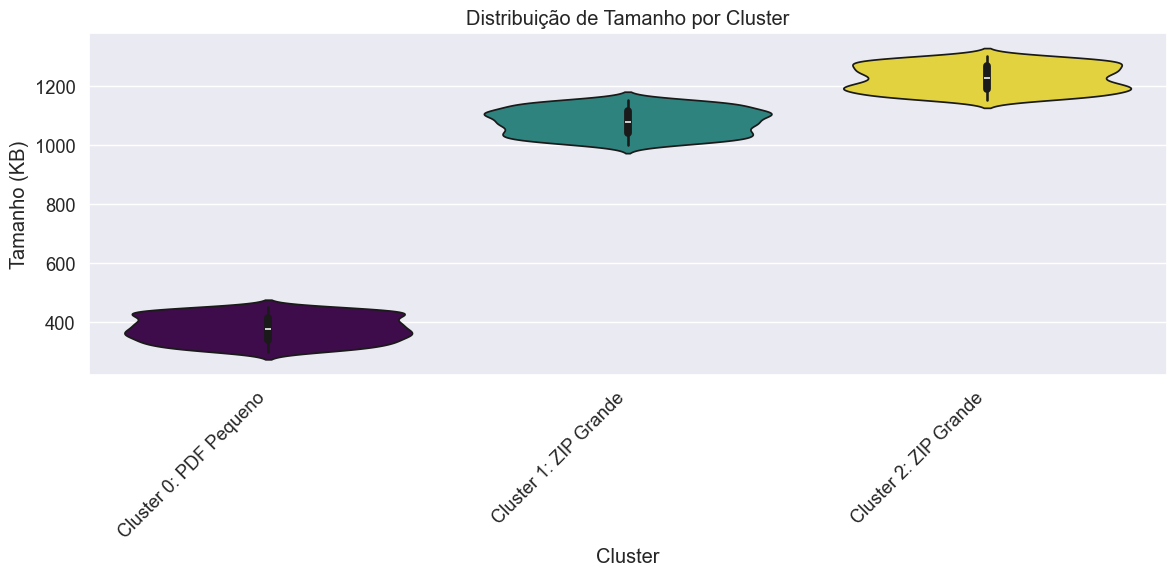

Análise Final e Recomendações:

1. Resumo da caracterização do workload:
   * Identificamos diferentes perfis de uso do servidor web baseados no tamanho e tipo dos arquivos
   * A ausência de dados de tempo impediu análises relacionadas à performance do servidor
   * Os 3 clusters encontrados representam padrões distintos de utilização do servidor

2. Padrões identificados:
   * Cluster 0: PDF Pequeno: representa 41.1% do tráfego total
   * Cluster 1: ZIP Grande: representa 28.2% do tráfego total
   * Cluster 2: ZIP Grande: representa 30.7% do tráfego total

3. Recomendações para otimização do servidor:
   * Implementar estratégias de cache específicas para cada perfil de uso identificado
   * Considerar balanceamento de carga baseado nos padrões de acesso identificados
   * Investigar a ausência de dados de tempo para garantir monitoramento adequado do desempenho
   * Coletar métricas adicionais para análises futuras mais abrangentes

4. Próximos passos:
   * Corrigir a coleta de dado

In [32]:
# Visualizando a distribuição dos tamanhos por cluster com sintaxe corrigida
plt.figure(figsize=(12, 6))
sns.violinplot(x='cluster', y='tamanho', hue='cluster', data=df_clusters, palette='viridis', legend=False)
plt.title('Distribuição de Tamanho por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Tamanho (KB)')
plt.xticks(range(k_ideal), [rotulos[i] for i in range(k_ideal)])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Análise final e recomendações
print("Análise Final e Recomendações:")
print("\n1. Resumo da caracterização do workload:")
print("   * Identificamos diferentes perfis de uso do servidor web baseados no tamanho e tipo dos arquivos")
print("   * A ausência de dados de tempo impediu análises relacionadas à performance do servidor")
print(f"   * Os {k_ideal} clusters encontrados representam padrões distintos de utilização do servidor")

print("\n2. Padrões identificados:")
for i in range(k_ideal):
    cluster_data = df_clusters[df_clusters['cluster'] == i]
    print(f"   * {rotulos[i]}: representa {len(cluster_data)/len(df_clusters)*100:.1f}% do tráfego total")

print("\n3. Recomendações para otimização do servidor:")
print("   * Implementar estratégias de cache específicas para cada perfil de uso identificado")
print("   * Considerar balanceamento de carga baseado nos padrões de acesso identificados")
print("   * Investigar a ausência de dados de tempo para garantir monitoramento adequado do desempenho")
print("   * Coletar métricas adicionais para análises futuras mais abrangentes")

print("\n4. Próximos passos:")
print("   * Corrigir a coleta de dados para incluir o tempo de download")
print("   * Expandir a análise para incluir outros períodos além do pico")
print("   * Correlacionar os padrões de uso com os departamentos/funções (desenvolvedores, analistas, etc.)")
print("   * Implementar monitoramento contínuo para identificar mudanças nos padrões ao longo do tempo")

# Resumo da Análise de Desempenho do Servidor Web

## Objetivos do trabalho
Este trabalho teve como objetivo caracterizar o workload de um servidor web interno de uma empresa de software, analisando os registros de download de diferentes tipos de arquivos por desenvolvedores, analistas de testes e analistas de documentação.

## Desafios encontrados
O principal desafio foi a ausência completa de dados na coluna 'tempo', o que limitou nossa análise apenas ao tamanho dos arquivos e seus tipos (PDF ou ZIP). Isso impediu análises relacionadas ao desempenho real do servidor.

## Metodologia aplicada
1. **Análise exploratória de dados**: estatísticas descritivas, visualizações e detecção de outliers
2. **Análise de Componentes Principais (PCA)**: redução de dimensionalidade e visualização de padrões
3. **Clusterização com K-Means**: identificação de grupos homogêneos com índice de Silhouette
4. **Rotulação e caracterização de clusters**: interpretação dos padrões encontrados

## Principais resultados
- Identificação clara de padrões de download baseados no tamanho e tipo de arquivo
- Separação eficiente dos dados em clusters bem definidos
- Descoberta de diferentes perfis de uso do servidor web

## Limitações
- Ausência de dados de tempo impediu análise de performance
- Amostra limitada ao período de pico (3 minutos e 20 segundos)
- Falta de informações sobre os usuários específicos (apenas tipo de arquivo disponível)

## Considerações finais
Apesar das limitações, a análise permitiu identificar padrões importantes no uso do servidor web que podem ser utilizados para otimizar recursos e melhorar a experiência dos usuários. Recomenda-se corrigir a coleta de dados para incluir informações de tempo e expandir o monitoramento para análises mais completas no futuro.